# Organize all the observations you have into one dataset

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import gsw
import datetime as dt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### unit conversion functions

In [2]:
def umolkg_to_uM(umolkg, temp_in_situ, salinity_absolute, pressure):
    """
    Convet from µmol/kg to µM (µmol/L) using in-situ temperature, salinity, and pressure.
    
    Parameters:
    - temp_in_situ: In-situ temperature in degrees Celsius.
    - salinity_absolute: Absolute salinity in g/kg.
    - pressure: Pressure in dbar (default is 0, corresponding to surface).
    
    Returns:
    - Dissolved oxygen in µM (µmol/L).
    """
    # Calculate seawater density using TEOS-10
    conservative_temp = gsw.CT_from_t(salinity_absolute, temp_in_situ, pressure)
    density_seawater = gsw.rho(salinity_absolute, conservative_temp, pressure)  # Density in kg/m^3
    
    # Convert µmol/kg to µmol/L (µM) using the seawater density
    uM = umolkg * (density_seawater / 1000)  # density_seawater is in kg/m^3, so divide by 1000 to convert to L
    
    return uM


def oxygen_mlL_to_uM(oxygen_mlL, temp_in_situ, salinity_absolute, pressure):
    """
    Convert dissolved oxygen from mL/L to µM (µmol/L) using in-situ temperature, salinity, and pressure.
    
    Parameters:
    - oxygen_mlL: Dissolved oxygen in mL/L.
    - temp_in_situ: In-situ temperature in degrees Celsius.
    - salinity_absolute: Absolute salinity in g/kg.
    - pressure: Pressure in dbar (default is 0, corresponding to surface).
    
    Returns:
    - Dissolved oxygen in µM (µmol/L).
    """
    # Constants
    R = 0.0821  # Ideal gas constant in L·atm/(mol·K)
    P = (pressure / 10) + 1  # Convert dbar to atmospheres (1 atm at surface)
    T_kelvin = temp_in_situ + 273.15  # Convert temperature to Kelvin
    
    # # Calculate molar volume of O2 under in-situ conditions (L/mol)
    # molar_volume_O2_in_situ = R * T_kelvin / P
    
    # Convert mL/L to µmol/L using the in-situ molar volume
    oxygen_umolL = P * oxygen_mlL * (1/R) * (1/T_kelvin)  # 1000 µmol in a mol
    
    return oxygen_umolL

### QA/QC functions

In [3]:
def _stdev(df, tracer):
    # cutoff outliers according to the standard deviation 
    data = df[tracer]

    # most data shouldn't have negative values so we can remove those
    # temperature can be slightly negative at the surface in the winter
    if tracer == 'temperature (degC)':
        lcut = -2
    else:
        lcut = 0

    # remove data less than lcut
    data[data<lcut] = np.nan # this line is changing temp[tracer] and idk why... but i guess that's OK

    # we want the standard deviation calculation to change with depth, so a new calc for a series of depth bins
    # lets do a bin every 100 m

    # depth binning:
    if np.max(df['depth (m)']) == np.min(df['depth (m)']):
        z = 0
    elif np.max(df['depth (m)']) > 800:
        z = np.append(np.append(np.arange(0,800,25),np.arange(800,np.max(df['depth (m)']),200)),np.max(df['depth (m)']))
    else:
        z = np.append(np.arange(0,np.max(df['depth (m)']),25),np.max(df['depth (m)']))


    if np.max(z) == 0:
            std = np.nanstd(data)
            mean = np.nanmean(data)
            z=0

            rcut = mean + 5*std
            lcut = mean - 5*std
    else:
        lcut, rcut = np.zeros(len(z)-1), np.zeros(len(z)-1)
        for i in range(len(z)-1):
            d = data[(df['depth (m)']>z[i]) & (df['depth (m)']<z[i+1])]

            std = np.nanstd(d)
            mean = np.nanmean(d)

            rcut[i] = mean + 5*std
            lcut[i] = mean - 5*std

    # for salinity at the surface we can have data all the way to zero (even if outside of stdev)
    if tracer == 'salinity (g kg-1)':
        lcut[0] = 0

    return lcut, rcut, z

def qaqc_plot(df, tracer, ax):
    #exploratory version of the stdev()
    lcut, rcut, z = _stdev(df, tracer)

    # plot original data with these cuttoffs 
    ax.scatter(df[tracer],df['depth (m)'], s=1)
    ax.set_title(tracer)
    ax.set_ylim([np.max(df['depth (m)']), -10])

    # and the cutoffs
    for i in range(len(z)-1):
        ax.plot([lcut[i],lcut[i]],[z[i], z[i+1]],'k--')
        ax.plot([rcut[i],rcut[i]],[z[i], z[i+1]],'k--')

def qaqc_trim(df, tracer):
    lcut, rcut, z = _stdev(df,tracer)

    if np.max(z) == 0:
        df[tracer][df[tracer] > rcut] = np.nan
        df[tracer][df[tracer] < lcut] = np.nan
    else:
        for i in range(len(z)-1):
            df[tracer][(df['depth (m)']>=z[i]) & (df['depth (m)']<z[i+1]) & (df[tracer] > rcut[i])] = np.nan
            df[tracer][(df['depth (m)']>=z[i]) & (df['depth (m)']<z[i+1]) & (df[tracer] < lcut[i])] = np.nan

    return df[tracer]


In [4]:
# note: uM = umol/L
d = {'time':[],'source':[],'longitude (degrees_east)':[],'latitude (degrees_north)':[],'depth (m)':[],'pressure (dbar)':[],
    'temperature (degC)':[], 'salinity (g kg-1)':[], 'DO (uM)':[], 'NO3 (uM)':[], 'NO2 (uM)':[], 'NH4 (uM)':[], 'PO4 (uM)':[], 'SiO4 (uM)':[], 
    'Chl (mg m-3)':[], 'TA (uM)':[], 'DIC (uM)':[], 'Carbonate':[], 'Aragonite':[], 'Calcite':[], 'Al (nM)':[], 'Ba (nM)':[], 'Cd (nM)':[],
     'Co (nM)':[], 'Cu (nM)':[], 'Fe (nM)':[], 'Ga (nM)':[], 'Mn (nM)':[], 'Ni (nM)':[], 'Pb (nM)':[], 'Zn (nM)':[]}

ob = pd.DataFrame(d)

### IOS mooring

In [5]:
m2005 =pd.read_pickle('./observations/IOS_ctd_moor_2005.p')
m2010 =pd.read_pickle('./observations/IOS_ctd_moor_2010.p')
m2015 =pd.read_pickle('./observations/IOS_ctd_moor_2015.p')
m2020 =pd.read_pickle('./observations/IOS_ctd_moor_2020.p')
ios_moor = pd.concat([m2005,m2010,m2015,m2020])
ios_moor.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),time
0,-123.424450,49.027150,13.177000,13.064797,9.5504,28.440600,NaN,2008-11-19 00:00:00+00:00
145,-126.203865,48.529617,40.143800,39.801180,NaN,32.426140,NaN,2009-05-24 00:00:00+00:00
146,-126.203865,48.529617,39.714828,39.375910,NaN,32.388807,NaN,2009-05-25 00:00:00+00:00
147,-126.203865,48.529617,39.632032,39.293829,NaN,32.367177,NaN,2009-05-26 00:00:00+00:00
148,-126.203865,48.529617,39.674800,39.336227,NaN,32.375100,NaN,2009-05-27 00:00:00+00:00


In [6]:
# convert to correct units
ios_moor['SA'] = gsw.conversions.SA_from_SP(ios_moor['sea_water_practical_salinity (PSS-78)'],ios_moor['sea_water_pressure (dbar)'],ios_moor['longitude (degrees_east)'],ios_moor['latitude (degrees_north)'])
ios_moor['DO'] = oxygen_mlL_to_uM(ios_moor['DOXYZZ01 (mL/L)'], ios_moor['sea_water_temperature (degC)'], ios_moor.SA, ios_moor['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_moor.time)
temp['longitude (degrees_east)'] = pd.to_numeric(ios_moor['longitude (degrees_east)'], errors='coerce')
temp['latitude (degrees_north)'] = pd.to_numeric(ios_moor['latitude (degrees_north)'], errors='coerce')
temp['pressure (dbar)'] = pd.to_numeric(ios_moor['sea_water_pressure (dbar)'], errors='coerce')
temp['depth (m)'] = pd.to_numeric(ios_moor['depth (m)'], errors='coerce')
temp['temperature (degC)'] = pd.to_numeric(ios_moor['sea_water_temperature (degC)'], errors='coerce')
temp['salinity (g kg-1)'] = pd.to_numeric(ios_moor['SA'], errors='coerce')
temp['DO (uM)'] = pd.to_numeric(ios_moor['DO'], errors='coerce')
temp['source'] ="ios mooring"

# ob = pd.concat([ob, temp])


In [7]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))

max = 35.07013355136922, min = -99.47604238345329, mean = 32.053532029436624
max = 14.908255555555556, min = -1.8228541666666667, mean = 7.528229885517284
max = 9.562222565086978, min = 0.42629904765574794, mean = 2.244568551873422


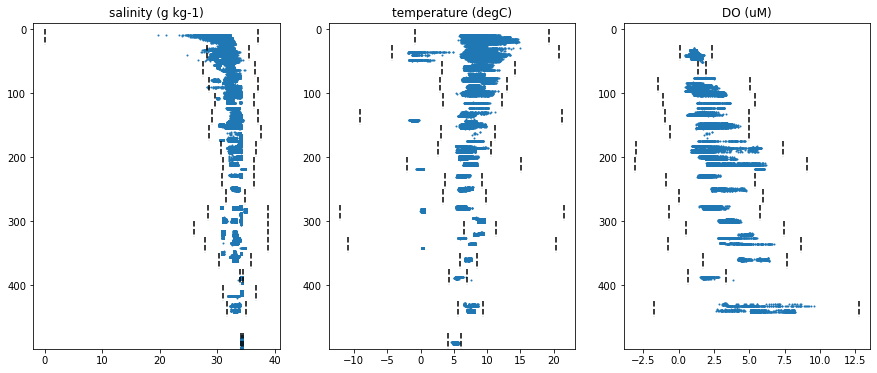

In [8]:
fig, ax = plt.subplots(1,3, figsize = (15, 6))

qaqc_plot(temp, 'salinity (g kg-1)', ax[0])
qaqc_plot(temp, 'temperature (degC)', ax[1])
qaqc_plot(temp, 'DO (uM)', ax[2])

In [9]:
# trim based on standard deviation 
temp['salinity (g kg-1)'] = qaqc_trim(temp, 'salinity (g kg-1)')
temp['temperature (degC)'] = qaqc_trim(temp, 'temperature (degC)')
temp['DO (uM)'] = qaqc_trim(temp, 'DO (uM)')

# add to main df
ob = pd.concat([ob, temp])

### IOS ctd profiles

In [10]:
p1965,p1967,p1969,p1971,p1973,p1975,p1977,p1979,p1981,p1983,p1985,p1987,p1989,p1991,p1993,p1995,p1997,p1999,p2001,p2003,p2005,p2007,p2009,p2011,p2013,p2015, p2017, p2018, p2019,p2020,p2021,p2022, p2023= pd.read_pickle('./observations/IOS_ctd_prof_1965.p'),pd.read_pickle('./observations/IOS_ctd_prof_1965.p'),pd.read_pickle('./observations/IOS_ctd_prof_1967.p'),pd.read_pickle('./observations/IOS_ctd_prof_1969.p'),pd.read_pickle('./observations/IOS_ctd_prof_1971.p'),pd.read_pickle('./observations/IOS_ctd_prof_1973.p'),pd.read_pickle('./observations/IOS_ctd_prof_1975.p'),pd.read_pickle('./observations/IOS_ctd_prof_1977.p'),pd.read_pickle('./observations/IOS_ctd_prof_1979.p'),pd.read_pickle('./observations/IOS_ctd_prof_1981.p'),pd.read_pickle('./observations/IOS_ctd_prof_1983.p'),pd.read_pickle('./observations/IOS_ctd_prof_1985.p'),pd.read_pickle('./observations/IOS_ctd_prof_1987.p'),pd.read_pickle('./observations/IOS_ctd_prof_1989.p'),pd.read_pickle('./observations/IOS_ctd_prof_1991.p'),pd.read_pickle('./observations/IOS_ctd_prof_1993.p'),pd.read_pickle('./observations/IOS_ctd_prof_1995.p'),pd.read_pickle('./observations/IOS_ctd_prof_1997.p'),pd.read_pickle('./observations/IOS_ctd_prof_1999.p'),pd.read_pickle('./observations/IOS_ctd_prof_2001.p'),pd.read_pickle('./observations/IOS_ctd_prof_2003.p'),pd.read_pickle('./observations/IOS_ctd_prof_2005.p'),pd.read_pickle('./observations/IOS_ctd_prof_2007.p'),pd.read_pickle('./observations/IOS_ctd_prof_2009.p'),pd.read_pickle('./observations/IOS_ctd_prof_2011.p'),pd.read_pickle('./observations/IOS_ctd_prof_2015.p'),pd.read_pickle('./observations/IOS_ctd_prof_2017.p'), pd.read_pickle('./observations/IOS_ctd_prof_2018.p'), pd.read_pickle('./observations/IOS_ctd_prof_2019.p'), pd.read_pickle('./observations/IOS_ctd_prof_2020.p'), pd.read_pickle('./observations/IOS_ctd_prof_2021.p'), pd.read_pickle('./observations/IOS_ctd_prof_2022.p'),pd.read_pickle('./observations/IOS_ctd_prof_2023.p')

ios_prof = pd.concat([p1965,p1967,p1969,p1971,p1973,p1975,p1977,p1979,p1981,p1983,p1985,p1987,p1989,p1991,p1993,p1995,p1997,p1999,p2001,p2003,p2005,p2007,p2009,p2011,p2013,p2015,p2017, p2018, p2019,p2020,p2021,p2022, p2023])
ios_prof.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),time
0,-127.726670,51.958332,3.458870,3.428571,NaN,29.642576,NaN,1966-05-17 00:00:00+00:00
1,-127.668335,52.021667,3.458890,3.428571,NaN,25.343174,NaN,1966-05-17 00:00:00+00:00
2,-127.661670,52.081665,3.458909,3.428571,NaN,24.428102,NaN,1966-05-18 00:00:00+00:00
3,-127.645000,52.081665,3.458909,3.428571,NaN,24.825585,NaN,1966-05-18 00:00:00+00:00
4,-127.630000,52.081665,3.458909,3.428571,NaN,24.155011,NaN,1966-05-18 00:00:00+00:00


In [11]:
# convert to correct units
ios_prof['SA'] = gsw.conversions.SA_from_SP(ios_prof['sea_water_practical_salinity (PSS-78)'],ios_prof['sea_water_pressure (dbar)'],ios_prof['longitude (degrees_east)'],ios_prof['latitude (degrees_north)'])
ios_prof['DO'] = oxygen_mlL_to_uM(ios_prof['DOXYZZ01 (mL/L)'], ios_prof['sea_water_temperature (degC)'], ios_prof.SA, ios_prof['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_prof.time)
temp['longitude (degrees_east)'] = ios_prof['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ios_prof['latitude (degrees_north)']
temp['pressure (dbar)'] = ios_prof['sea_water_pressure (dbar)']
temp['depth (m)'] = ios_prof['depth (m)']
temp['temperature (degC)'] = ios_prof['sea_water_temperature (degC)']
temp['salinity (g kg-1)'] = ios_prof['SA']
temp['DO (uM)'] = ios_prof['DO']
temp['source'] ="ios ctd profiles"

# ob = pd.concat([ob, temp])

In [12]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))

max = 70.63849307913043, min = -100.32757187724715, mean = 32.712900111358685
max = 30.101056399999997, min = -5.60565499, mean = 6.914254962602034
max = 16.056602152936957, min = -20.447437180927878, mean = 2.308466237738658


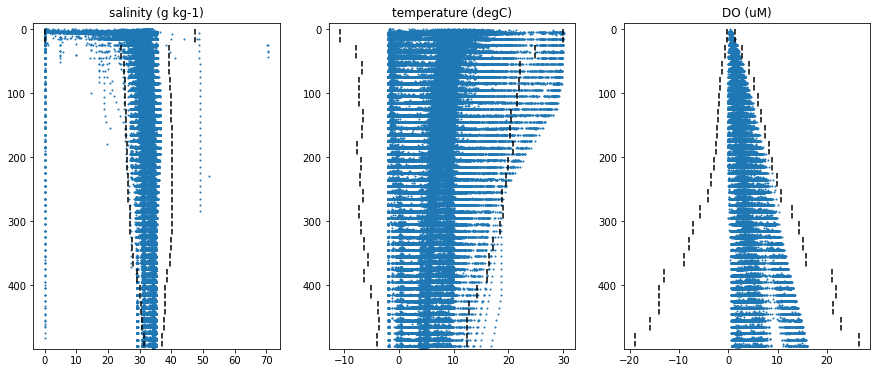

In [13]:
fig, ax = plt.subplots(1,3, figsize = (15, 6))

qaqc_plot(temp, 'salinity (g kg-1)', ax[0])
qaqc_plot(temp, 'temperature (degC)', ax[1])
qaqc_plot(temp, 'DO (uM)', ax[2])

In [14]:
# trim based on standard deviation 
temp['salinity (g kg-1)'] = qaqc_trim(temp, 'salinity (g kg-1)')
temp['temperature (degC)'] = qaqc_trim(temp, 'temperature (degC)')
temp['DO (uM)'] = qaqc_trim(temp, 'DO (uM)')

# add to main df
ob = pd.concat([ob, temp])

### IOS bottles

In [15]:
b1930 =pd.read_pickle('./observations/IOS_bot_prof_1930.p')
b1940 =pd.read_pickle('./observations/IOS_bot_prof_1940.p')
b1950 =pd.read_pickle('./observations/IOS_bot_prof_1950.p')
b1960 =pd.read_pickle('./observations/IOS_bot_prof_1960.p')
b1970 =pd.read_pickle('./observations/IOS_bot_prof_1970.p')
b1980 =pd.read_pickle('./observations/IOS_bot_prof_1980.p')
b1990 =pd.read_pickle('./observations/IOS_bot_prof_1990.p')
b2000 =pd.read_pickle('./observations/IOS_bot_prof_2000.p')
b2010 =pd.read_pickle('./observations/IOS_bot_prof_2010.p')
b2020 =pd.read_pickle('./observations/IOS_bot_prof_2020.p')
ios_bot = pd.concat([b1930, b1940,b1950,b1960,b1970,b1980,b1990,b2000,b2010,b2020])
ios_bot.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),DOXMZZ01 (umol/kg),NTRZAAZ1 (umol/L),SLCAAAZ1 (umol/L),PHOSAAZ1 (umol/L),CPHLFLP1 (mg/m^3),time
0,-133.363,54.673,0.0,0.0,NaN,31.957418,6.33,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
1,-133.335,54.553,0.0,0.0,NaN,32.177610,6.33,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
2,-133.287,54.190,0.0,0.0,NaN,31.527050,6.66,NaN,NaN,NaN,NaN,NaN,1938-05-30 00:00:00+00:00
3,-133.253,54.420,0.0,0.0,NaN,31.266827,7.00,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
4,-133.183,54.270,0.0,0.0,NaN,31.507032,6.89,NaN,NaN,NaN,NaN,NaN,1938-05-30 00:00:00+00:00


In [16]:
# convert to correct units
ios_bot['SA'] = gsw.conversions.SA_from_SP(ios_bot['sea_water_practical_salinity (PSS-78)'],ios_bot['sea_water_pressure (dbar)'],ios_bot['longitude (degrees_east)'],ios_bot['latitude (degrees_north)'])
ios_bot['DO'] = oxygen_mlL_to_uM(ios_bot['DOXYZZ01 (mL/L)'], ios_bot['sea_water_temperature (degC)'], ios_bot.SA, ios_bot['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_bot.time)
temp['longitude (degrees_east)'] = ios_bot['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ios_bot['latitude (degrees_north)']
temp['pressure (dbar)'] = ios_bot['sea_water_pressure (dbar)']
temp['depth (m)'] = ios_bot['depth (m)']
temp['temperature (degC)'] = ios_bot['sea_water_temperature (degC)']
temp['salinity (g kg-1)'] = ios_bot['SA']
temp['DO (uM)'] = ios_bot['DO']
temp['NO3 (uM)'] = ios_bot['NTRZAAZ1 (umol/L)']
temp['PO4 (uM)'] = ios_bot['SLCAAAZ1 (umol/L)']
temp['SiO4 (uM)'] = ios_bot['PHOSAAZ1 (umol/L)']
temp['Chl (mg m-3)'] = ios_bot['CPHLFLP1 (mg/m^3)']

temp['source'] ="ios bottle"

# ob = pd.concat([ob, temp])

In [17]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['SiO4 (uM)']),np.min(temp['SiO4 (uM)']),np.mean(temp['SiO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Chl (mg m-3)']),np.min(temp['Chl (mg m-3)']),np.mean(temp['Chl (mg m-3)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))

# here we clearly have problems

max = 93.3, min = -99.0, mean = 19.786764538708233
max = 1080.0, min = -100.0, mean = 36.5954518586751
max = 708.0, min = -99.0, mean = 2.075869845861794
max = 191.2, min = -99.0, mean = 1.083480448676354
max = 16.111621634571357, min = -157.14357714809165, mean = 1.8719233148371655


In [18]:
temp['time'] = pd.to_datetime(temp.time, utc=True)
temp['longitude (degrees_east)'] = pd.to_numeric(temp['longitude (degrees_east)'], errors='coerce')
temp['latitude (degrees_north)'] = pd.to_numeric(temp['latitude (degrees_north)'], errors='coerce')
temp['depth (m)'] = pd.to_numeric(temp['depth (m)'], errors='coerce')
temp['pressure (dbar)'] = pd.to_numeric(temp['pressure (dbar)'], errors='coerce')
temp['temperature (degC)'] = pd.to_numeric(temp['temperature (degC)'], errors='coerce')
temp['salinity (g kg-1)'] = pd.to_numeric(temp['salinity (g kg-1)'], errors='coerce')
temp['DO (uM)'] = pd.to_numeric(temp['DO (uM)'], errors='coerce')
temp['NO3 (uM)'] = pd.to_numeric(temp['NO3 (uM)'], errors='coerce')
temp['PO4 (uM)'] = pd.to_numeric(temp['PO4 (uM)'], errors='coerce')
temp['SiO4 (uM)'] = pd.to_numeric(temp['SiO4 (uM)'], errors='coerce')

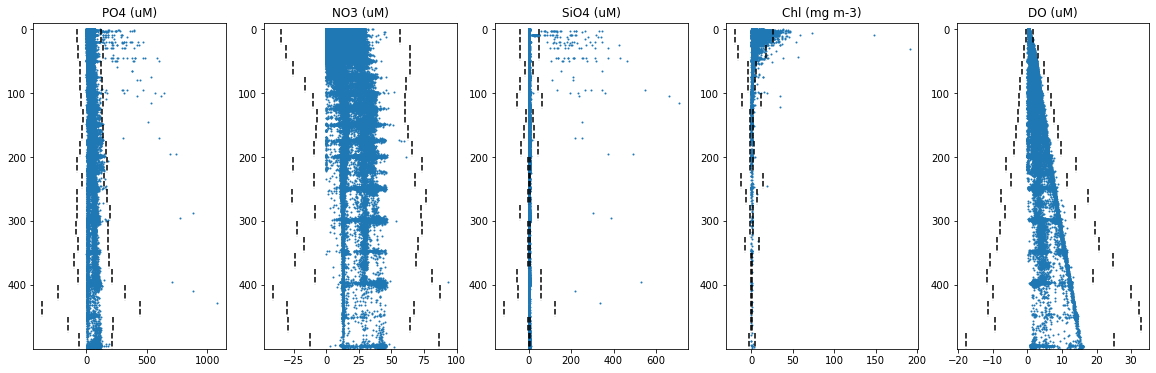

In [19]:
# lets see if there are any clear anomalies
test = ['PO4 (uM)', 'NO3 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'DO (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [20]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

In [21]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['SiO4 (uM)']),np.min(temp['SiO4 (uM)']),np.mean(temp['SiO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Chl (mg m-3)']),np.min(temp['Chl (mg m-3)']),np.mean(temp['Chl (mg m-3)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))

max = 61.2, min = 0.0, mean = 19.83498989638908
max = 188.0, min = 0.0, mean = 36.25966777820592
max = 45.7, min = 0.0, mean = 1.8231852564671571
max = 25.46, min = 0.0, mean = 1.8644858451072661
max = 16.111621634571357, min = 0.0, mean = 1.8791772780867477


In [22]:
ob = pd.concat([ob, temp])

### OOI
i have some suspicions that these are completely covered by the NCEI Coastal dataset..

In [23]:
ooi_chl = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_chlorophyll.p')
ooi_chl.head()

# convert to correct units
ooi_chl['SA'] = gsw.conversions.SA_from_SP(ooi_chl['sea_water_practical_salinity (1e-3)'],ooi_chl['z (m)'],ooi_chl['longitude (degrees_east)'],ooi_chl['latitude (degrees_north)'])
# note microgram/L = mg/m3

# # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_chl.datetime)
temp['longitude (degrees_east)'] = ooi_chl['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_chl['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_chl['z (m)']
temp['depth (m)'] = ooi_chl['z (m)']
temp['temperature (degC)'] = ooi_chl['sea_water_temperature (degree_Celsius)']
temp['salinity (g kg-1)'] = ooi_chl['SA']
temp['Chl (mg m-3)'] = ooi_chl['mass_concentration_of_chlorophyll_a_in_sea_water (microg.L-1)']
temp['source'] ="ooi"

# ob = pd.concat([ob, temp])

In [24]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Chl (mg m-3)']),np.min(temp['Chl (mg m-3)']),np.mean(temp['Chl (mg m-3)'])))

max = 34.81144328036963, min = 0.0, mean = 31.68161900338307
max = 19.989569981186115, min = 1.7182868536, mean = 11.29062512802854
max = 5549.966065583712, min = -0.672, mean = 2.7059416356074566


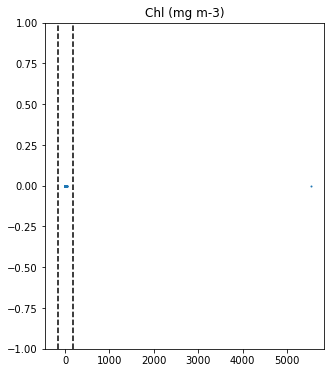

In [25]:
# something seems wrong with chlorophyll
# lets see if there are any clear anomalies
test = 'Chl (mg m-3)'
fig, ax = plt.subplots(1,1, figsize = (5, 6))
ax.scatter(temp[test],temp['depth (m)'], s=1, label=test)

ax.set_title(test)

ax.set_ylim([-1,1])

l, r, _ = _stdev(temp, test)
ax.plot([l,l],[-1,1],'k--')
ax.plot([r,r],[-1,1],'k--')

In [26]:
# trim based on standard deviation 
temp[test] = qaqc_trim(temp, test)

# and add to df
ob = pd.concat([ob, temp])

In [27]:
ooi_co2 = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_co2.p')
ooi_co2.head() # not included for now

,z (m),latitude (degrees_north),longitude (degrees_east),partial_pressure_of_carbon_dioxide_in_sea_water (microatm),partial_pressure_of_carbon_dioxide_in_sea_water_qc_agg,datetime
0,0.0,44.65695,-124.09553,353.764967,1.0,2014-04-21 15:00:00+00:00
1,NaN,NaN,NaN,NaN,NaN,2014-04-21 16:00:00+00:00
2,NaN,NaN,NaN,NaN,NaN,2014-04-21 17:00:00+00:00
3,0.0,44.65695,-124.09553,1009.055819,3.0,2014-04-21 18:00:00+00:00
4,NaN,NaN,NaN,NaN,NaN,2014-04-21 19:00:00+00:00


In [28]:
ooi_oxy = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_oxygen.p')
ooi_oxy.head()

# # convert to correct units
ooi_oxy['SA'] = gsw.conversions.SA_from_SP(ooi_oxy['sea_water_practical_salinity (1e-3)'],ooi_oxy['z (m)'],ooi_oxy['longitude (degrees_east)'],ooi_oxy['latitude (degrees_north)'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_oxy.datetime)
temp['longitude (degrees_east)'] = ooi_oxy['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_oxy['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_oxy['z (m)']
temp['depth (m)'] = ooi_oxy['z (m)']
temp['temperature (degC)'] = ooi_oxy['sea_water_temperature (degree_Celsius)']
temp['salinity (g kg-1)'] = ooi_oxy['SA']
temp['DO (uM)'] = ooi_oxy['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)']
temp['source'] ="ooi"

# ob = pd.concat([ob, temp])

In [29]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))

max = 36.460942828204935, min = 0.0, mean = 32.95254665324082
max = 19.989545093594533, min = 1.6963244068328474, mean = 7.886019818849728
max = 28011.887339058, min = -1009.9999000000009, mean = 125.29526389278399


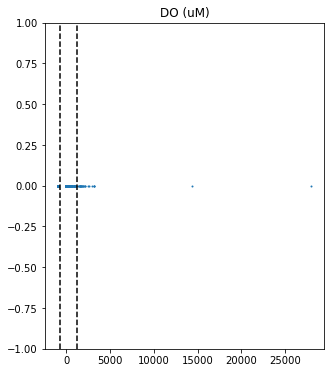

In [30]:
# lets see if there are any clear anomalies
test = 'DO (uM)'
fig, ax = plt.subplots(1,1, figsize = (5, 6))
ax.scatter(temp[test],temp['depth (m)'], s=1, label=test)

ax.set_title(test)

ax.set_ylim([-1,1])
# ax.set_xlim([0,5000])

l, r, _ = _stdev(temp, test)
ax.plot([l,l],[-1,1],'k--')
ax.plot([r,r],[-1,1],'k--')

In [31]:
# trim based on standard deviation 
temp[test] = qaqc_trim(temp, test)

# and add to df
ob = pd.concat([ob, temp])

In [32]:
ooi_nit = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_nitrate.p')
ooi_nit.head()

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_nit.datetime)
temp['longitude (degrees_east)'] = ooi_nit['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_nit['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_nit['z (m)']
temp['depth (m)'] = ooi_nit['z (m)']
temp['NO3 (uM)'] = ooi_nit['mole_concentration_of_nitrate_in_sea_water (micromol.L-1)']
temp['source'] ="ooi"

# ob = pd.concat([ob, temp])


In [33]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))

max = 855.3548817981541, min = -48.81902652567501, mean = 30.59398804190267


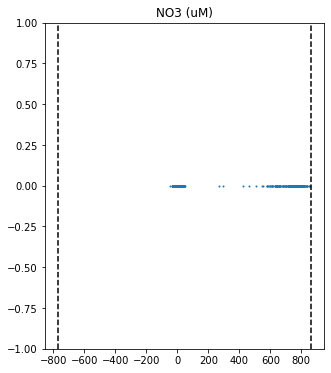

In [34]:
# lets see if there are any clear anomalies
test = 'NO3 (uM)'
fig, ax = plt.subplots(1,1, figsize = (5, 6))
ax.scatter(temp[test],temp['depth (m)'], s=1, label=test)

ax.set_title(test)

ax.set_ylim([-1,1])
# ax.set_xlim([0,5000])

l, r, _ = _stdev(temp, test)
ax.plot([l,l],[-1,1],'k--')
ax.plot([r,r],[-1,1],'k--')

In [35]:
# trim based on standard deviation 
temp[test] = qaqc_trim(temp, test)

# and add to df
ob = pd.concat([ob, temp])

### ONC

In [36]:
onc = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/ONC.p')

# combine the two temperature columns together
onc['temperature (degC)'] = onc['temperature (K)'].fillna(0)+onc['Temperature (K)'].fillna(0) - 273
onc.drop(['temperature (K)','Temperature (K)','datetime'],axis=1,inplace=True)
onc.head()

# # convert to correct units
onc['SA'] = gsw.conversions.SA_from_SP(onc['salinity (1e-3)'],onc['depth (m)'],onc['longitude (degrees_east)'],onc['latitude (degrees_north)'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(onc.time)
temp['longitude (degrees_east)'] = onc['longitude (degrees_east)']
temp['latitude (degrees_north)'] = onc['latitude (degrees_north)']
temp['pressure (dbar)'] = onc['depth (m)']
temp['depth (m)'] = onc['depth (m)']
temp['temperature (degC)'] = onc['temperature (degC)']
temp['salinity (g kg-1)'] = onc['SA']
temp['source'] ="onc"

# ob = pd.concat([ob, temp])

In [37]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))

max = 55.80217634936233, min = 0.009419097038352342, mean = 31.866383132308734
max = 22.481497938775476, min = 0.14999999999997726, mean = 8.206351698377548


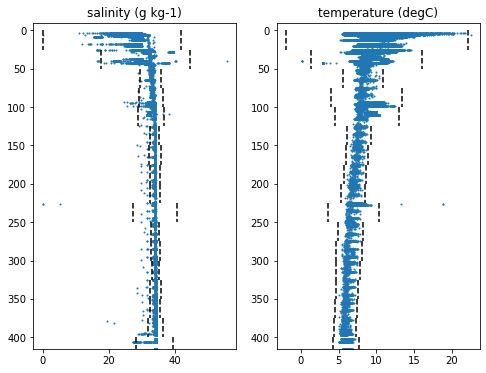

In [38]:
# lets see if there are any clear anomalies
test = ['salinity (g kg-1)', 'temperature (degC)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [39]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

# and add to df
ob = pd.concat([ob, temp])

### Department of Ecology

In [40]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1999,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ecology_nc/bottle/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ecob = pd.concat(dataframes, ignore_index=True)
ecob.head()

# convert to correct units
ecob['z'] = ecob['z']*-1
ecob['T'] = gsw.conversions.t_from_CT(ecob['SA'],ecob['CT'],ecob['z'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ecob.time)
temp['longitude (degrees_east)'] = ecob['lon']
temp['latitude (degrees_north)'] = ecob['lat']
temp['pressure (dbar)'] = ecob['z']
temp['depth (m)'] = ecob['z']
temp['temperature (degC)'] = ecob['T']
temp['salinity (g kg-1)'] = ecob['SA']
temp['DO (uM)'] = ecob['DO (uM)']
temp['Chl (mg m-3)'] = ecob['Chl (mg m-3)']
temp['NO3 (uM)'] = ecob['NO3 (uM)']
temp['NH4 (uM)'] = ecob['NH4 (uM)']
temp['PO4 (uM)'] = ecob['PO4 (uM)']
temp['SiO4 (uM)'] = ecob['SiO4 (uM)']

temp['source'] ="department of ecology"

# ob = pd.concat([ob, temp])

In [41]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['Chl (mg m-3)']),np.min(temp['Chl (mg m-3)']),np.mean(temp['Chl (mg m-3)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['SiO4 (uM)']),np.min(temp['SiO4 (uM)']),np.mean(temp['SiO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['NH4 (uM)']),np.min(temp['NH4 (uM)']),np.mean(temp['NH4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))


# pretty high max NO3 and SiO4

max = 167.40679931640625, min = -0.18549999594688416, mean = 3.8614284992218018
max = 76.1500015258789, min = 0.0, mean = 18.357629776000977
max = 6.239999771118164, min = 0.0, mean = 1.8969045877456665
max = 302.9700012207031, min = 1.5399999618530273, mean = 51.50456619262695
max = 104.0, min = 0.0, mean = 1.2148892879486084
max = 33.682303984338944, min = 0.028033936852175912, mean = 28.329204054914936
max = 611.3125, min = 6.971875190734863, mean = 250.3255157470703
max = 23.99079918464234, min = 3.5862000022743845, mean = 10.917778856669981


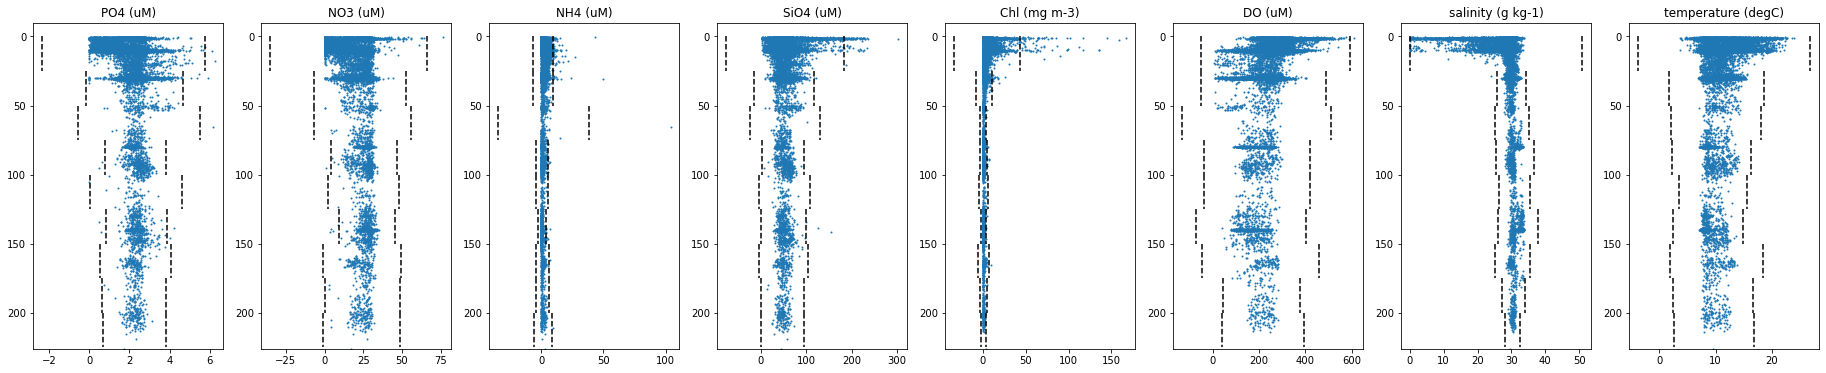

In [42]:
# lets see if there are any clear anomalies
test = ['PO4 (uM)', 'NO3 (uM)', 'NH4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'DO (uM)','salinity (g kg-1)', 'temperature (degC)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])


In [43]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

# and add to df
ob = pd.concat([ob, temp])

In [44]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1999,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ecology_nc/ctd/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ecoc = pd.concat(dataframes, ignore_index=True)
ecoc.head()

# convert to correct units
ecoc['z'] = ecoc['z']*-1
ecoc['T'] = gsw.conversions.t_from_CT(ecoc['SA'],ecoc['CT'],ecoc['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ecoc.time)
temp['longitude (degrees_east)'] = ecoc['lon']
temp['latitude (degrees_north)'] = ecoc['lat']
temp['pressure (dbar)'] = ecoc['z']
temp['depth (m)'] = ecoc['z']
temp['temperature (degC)'] = ecoc['T']
temp['salinity (g kg-1)'] = ecoc['SA']
temp['DO (uM)'] = ecoc['DO (uM)']
temp['Chl (mg m-3)'] = ecoc['Chl (mg m-3)']

temp['source'] ="department of ecology"

# ob = pd.concat([ob, temp])

In [45]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['Chl (mg m-3)']),np.min(temp['Chl (mg m-3)']),np.mean(temp['Chl (mg m-3)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))

max = 195.9257049560547, min = -0.39559999108314514, mean = 1.9468128681182861
max = 33.879031137814096, min = 0.02331149285392424, mean = 29.93128549780927
max = 699.65625, min = 0.0, mean = 218.09750366210938
max = 24.097097601406656, min = 3.012588957390299, mean = 10.10106437780492


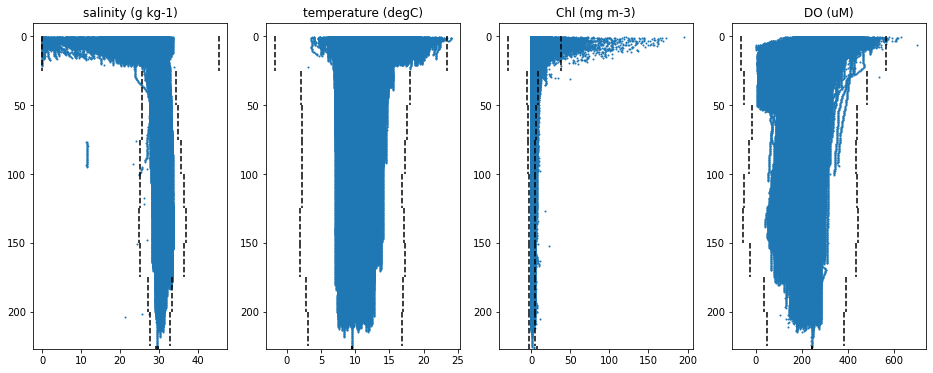

In [46]:
# lets see if there are any clear anomalies
test = ['salinity (g kg-1)', 'temperature (degC)', 'Chl (mg m-3)', 'DO (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [47]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

# and add to df
ob = pd.concat([ob, temp])

### NCEI
##### PNW

In [48]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = [1985,1986,1989] + list(np.arange(1991,2008+1,1)) + [2010,2013,2014,2015,2016,2017]

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/nceiPNW/bottle/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
pncei = pd.concat(dataframes, ignore_index=True)
pncei.head()

# convert to correct units
pncei['z'] = pncei['z']*-1
pncei['T'] = gsw.conversions.t_from_CT(pncei['SA'],pncei['CT'],pncei['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(pncei.time)
temp['longitude (degrees_east)'] = pncei['lon']
temp['latitude (degrees_north)'] = pncei['lat']
temp['pressure (dbar)'] = pncei['z']
temp['depth (m)'] = pncei['z']
temp['temperature (degC)'] = pncei['T']
temp['salinity (g kg-1)'] = pncei['SA']
temp['DO (uM)'] = pncei['DO (uM)']
temp['NO3 (uM)'] = pncei['NO3 (uM)']
temp['PO4 (uM)'] = pncei['PO4 (uM)']
temp['TA (uM)'] = pncei['TA (uM)']
temp['DIC (uM)'] = pncei['DIC (uM)']


temp['source'] ="NCEI PNW"

# ob = pd.concat([ob, temp])

In [49]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['DIC (uM)']),np.min(temp['DIC (uM)']),np.mean(temp['DIC (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['TA (uM)']),np.min(temp['TA (uM)']),np.mean(temp['TA (uM)'])))

# reasonable range

max = 47.264142326819055, min = 0.0, mean = 24.110871017385616
max = 395.66857187561243, min = 4.515742464929881, mean = 159.0853034565913
max = 3.9307485547003274, min = 0.13137246505634434, mean = 1.9152959014395168
max = 2493.5756556454735, min = 1754.7276853762448, mean = 2222.3940706494095
max = 2516.4938292905335, min = 2023.0630359708514, mean = 2309.2242456454856


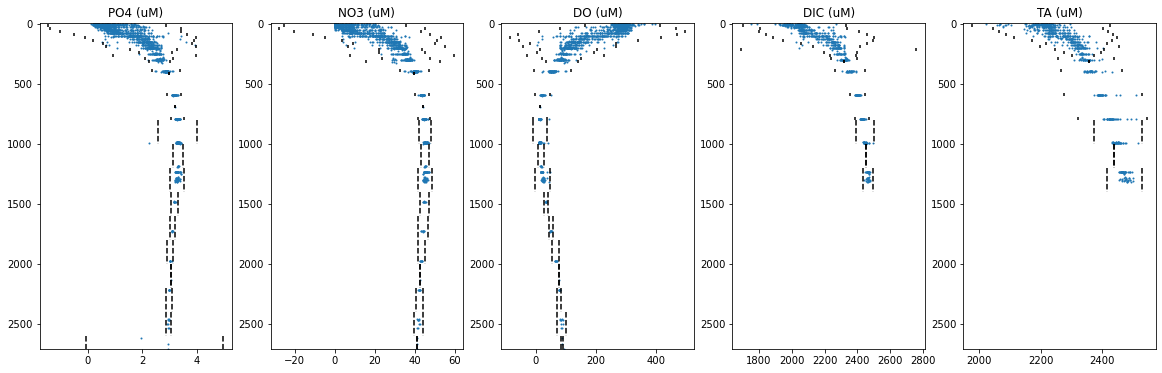

In [50]:
# lets see if there are any clear anomalies
test = ['PO4 (uM)', 'NO3 (uM)', 'DO (uM)', 'DIC (uM)', 'TA (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [51]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

ob = pd.concat([ob, temp])

##### Coastal

In [52]:
cncei = pd.read_csv('/data/rbeutel/obs/nceiCoastal/bottle/CODAP_NA_v2021.csv').drop(0)

# replace all -999 values with np.nan
cncei.replace(-999,np.nan, inplace=True)
cncei.replace('-999',np.nan, inplace=True)

# convert to correct units
cncei['SA'] = gsw.conversions.SA_from_SP(pd.to_numeric(cncei['recommended_Salinity_PSS78']),pd.to_numeric(cncei['CTDPRES']),pd.to_numeric(cncei['Longitude']),pd.to_numeric(cncei['Latitude']))

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = [dt.datetime(int(cncei.Year_UTC[i]), int(cncei.Month_UTC[i]), int(cncei.Day_UTC[i]), int(float(cncei.Time_UTC[i])*24)) for i in cncei.index]
temp['longitude (degrees_east)'] = pd.to_numeric(cncei['Longitude'])
temp['latitude (degrees_north)'] = pd.to_numeric(cncei['Latitude'])
temp['pressure (dbar)'] = pd.to_numeric(cncei['CTDPRES'])
temp['depth (m)'] = pd.to_numeric(cncei['Depth'])
temp['temperature (degC)'] = pd.to_numeric(cncei['CTDTEMP_ITS90'])
temp['salinity (g kg-1)'] = pd.to_numeric(cncei['SA'])
temp['DO (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['recommended_Oxygen']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['DIC (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['DIC']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['TA (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['TALK']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Aragonite'] = umolkg_to_uM(pd.to_numeric(cncei['Aragonite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Calcite'] = umolkg_to_uM(pd.to_numeric(cncei['Calcite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Carbonate'] = umolkg_to_uM(pd.to_numeric(cncei['Carbonate_measured']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['PO4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Phosphate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['SiO4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Silicate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO3 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Nitrate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO2 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Nitrite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NH4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Ammonium']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])

temp['source'] ="NCEI Coastal"

# ob = pd.concat([ob, temp])

In [53]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO2 (uM)']),np.min(temp['NO2 (uM)']),np.mean(temp['NO2 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['NH4 (uM)']),np.min(temp['NH4 (uM)']),np.mean(temp['NH4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['SiO4 (uM)']),np.min(temp['SiO4 (uM)']),np.mean(temp['SiO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('\n')
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
print('\n')
print('max = %s, min = %s, mean = %s' % (np.max(temp['DIC (uM)']),np.min(temp['DIC (uM)']),np.mean(temp['DIC (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['TA (uM)']),np.min(temp['TA (uM)']),np.mean(temp['TA (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Aragonite']),np.min(temp['Aragonite']),np.mean(temp['Aragonite'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Calcite']),np.min(temp['Calcite']),np.mean(temp['Calcite'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['Carbonate']),np.min(temp['Carbonate']),np.mean(temp['Carbonate'])))

# reasonable range

max = 52.69242789458168, min = 0.0, mean = 15.80177208763971
max = 3.8435468572156615, min = 0.0, mean = 0.09628999196547909
max = 8.123458510704495, min = 0.0, mean = 0.5971372149135805
max = 244.1542764909346, min = 0.0, mean = 24.963982905198026
max = 3.75637362977433, min = 0.0, mean = 1.2518822542621924


max = 508.04556206678984, min = 2.77897540049069, mean = 227.74730945132083
max = 37.788817807610656, min = 0.11756000913919495, mean = 33.47502972887882
max = 31.735, min = -1.786, mean = 10.325033743746259


max = 2677.039133278803, min = 886.4977859979249, mean = 2158.7999116633187
max = 2914.981116811543, min = 878.0968593255619, mean = 2307.985392498789
max = 5.198407808332977, min = 0.34360891704221663, mean = 1.7506818656009662
max = 7.817997625473321, min = 0.5861563878955459, mean = 2.72765371173365
max = 303.9941722673797, min = 39.65803935168331, mean = 135.37686343089908


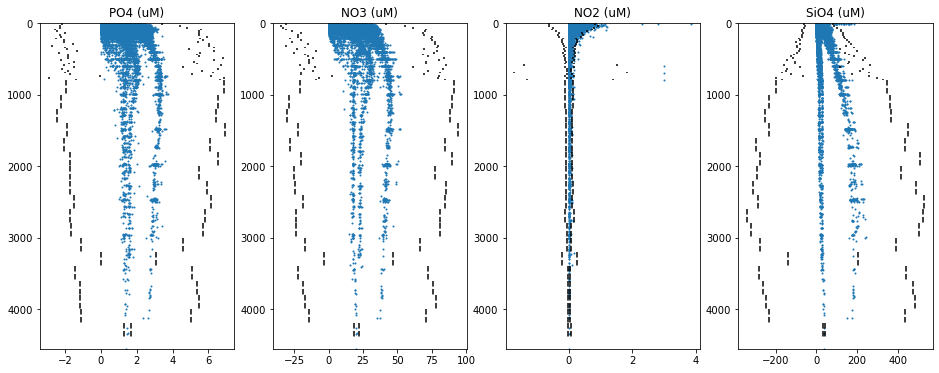

In [54]:
# lets see if there are any clear anomalies
test = ['PO4 (uM)', 'NO3 (uM)', 'NO2 (uM)', 'SiO4 (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [55]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

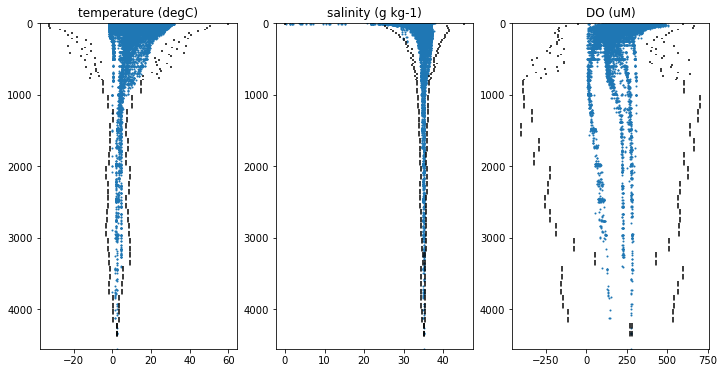

In [56]:
# lets see if there are any clear anomalies
test = ['temperature (degC)', 'salinity (g kg-1)', 'DO (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [57]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

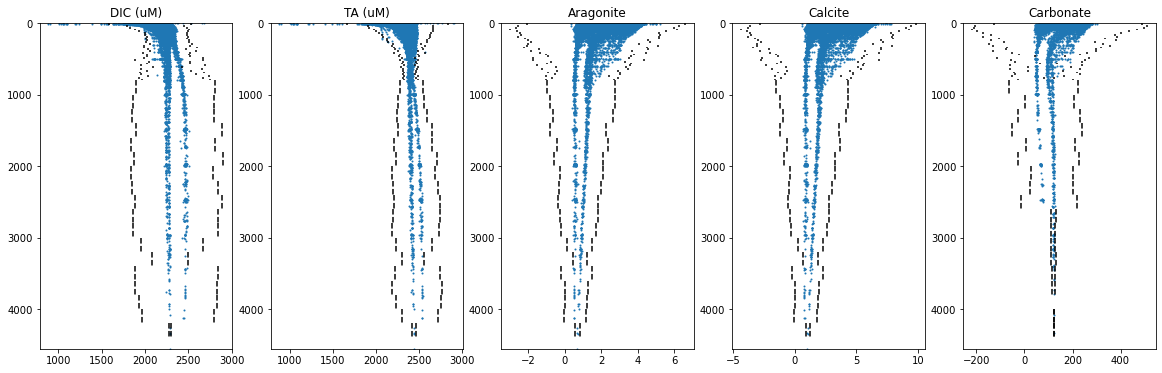

In [58]:
# lets see if there are any clear anomalies
test = ['DIC (uM)', 'TA (uM)', 'Aragonite', 'Calcite', 'Carbonate']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [59]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

In [60]:
ob = pd.concat([ob, temp])

### OCNMS

In [61]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(2004,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ocnms_ctd/ctd/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ocnms = pd.concat(dataframes, ignore_index=True)
ocnms.head()

# convert to correct units
ocnms['z'] = ocnms['z']*-1
ocnms['T'] = gsw.conversions.t_from_CT(ocnms['SA'],ocnms['CT'],ocnms['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ocnms.time)
temp['longitude (degrees_east)'] = ocnms['lon']
temp['latitude (degrees_north)'] = ocnms['lat']
temp['pressure (dbar)'] = ocnms['z']
temp['depth (m)'] = ocnms['z']
temp['temperature (degC)'] = ocnms['T']
temp['salinity (g kg-1)'] = ocnms['SA']
temp['DO (uM)'] = ocnms['DO (uM)']

temp['source'] ="OCNMS"

# ob = pd.concat([ob, temp])

In [62]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))
# reasonable range

max = 567.2080688476562, min = 3.867642402648926, mean = 187.63925170898438
max = 35.25347736508091, min = 18.098472601032462, mean = 32.8403537642303
max = 17.7995964531052, min = 6.471335431385989, mean = 9.727172440443097


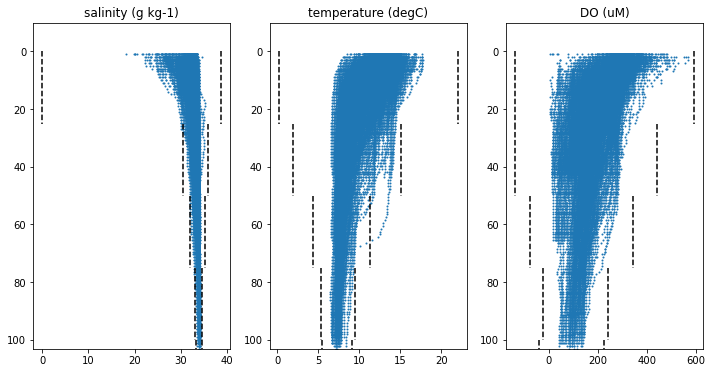

In [63]:
# lets see if there are any clear anomalies
test = ['salinity (g kg-1)', 'temperature (degC)', 'DO (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [64]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

ob = pd.concat([ob, temp])

### NHL

In [65]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1997,2021+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/NHL/ctd/{year}.csv'
    
    # Read the pickled dataframe
    df = pd.read_csv(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
nhl = pd.concat(dataframes, ignore_index=True)

# drop -9999 values
nhl.replace(-9999, np.nan, inplace=True)

nhl.head()

# convert to correct units
nhl['DO'] = oxygen_mlL_to_uM(nhl['DO (ml/L)'], nhl['temperature (degC)'], nhl.salinity, nhl['pressure (dbar)'])


# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(nhl.datetime)
temp['longitude (degrees_east)'] = nhl['lon']
temp['latitude (degrees_north)'] = nhl['lat']
temp['pressure (dbar)'] = nhl['pressure (dbar)']
temp['depth (m)'] = nhl['pressure (dbar)']
temp['temperature (degC)'] = nhl['temperature (degC)']
temp['salinity (g kg-1)'] = nhl['salinity']
temp['DO (uM)'] = nhl['DO']

temp['source'] ="NHL"

# ob = pd.concat([ob, temp])

In [66]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))

max = 46.23804095139439, min = -0.08286435145252105, mean = 1.5929127570567703
max = 65.888, min = 15.712, mean = 33.4933781874592
max = 19.656, min = 1.7193, mean = 7.791337495408793


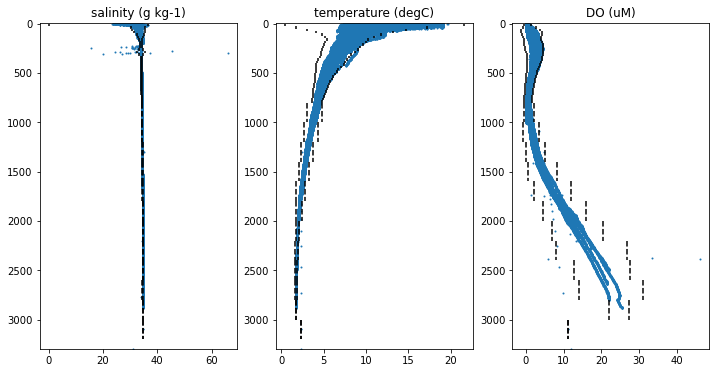

In [67]:
# lets see if there are any clear anomalies
test = ['salinity (g kg-1)', 'temperature (degC)', 'DO (uM)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [68]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

# and add to df
ob = pd.concat([ob, temp])

### GEOTRACES

In [69]:
geo = xr.open_dataset("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/GEOTRACES/data_from_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2.nc")

In [70]:
temp = pd.DataFrame(d)

# ok so if we flatten a single variable it looks like 52 arrays of length 290 lined up therefore we should make the variable descrition as follows:
temp['time'] = np.repeat(geo.date_time.values,290)
temp['longitude (degrees_east)'] = np.repeat(geo.longitude.values,290)
temp['latitude (degrees_north)'] = np.repeat(geo.latitude.values,290)
temp['depth (m)'] = geo.DEPTH.values.flatten()
temp['pressure (dbar)'] = geo.CTDPRS_T_VALUE_SENSOR.values.flatten()
temp['temperature (degC)'] = geo.CTDTMP_T_VALUE_SENSOR.values.flatten()
temp['salinity (g kg-1)'] = gsw.conversions.SA_from_SP(geo.SALINITY_D_CONC_BOTTLE.values.flatten(), temp['pressure (dbar)'].values, temp['longitude (degrees_east)'].values, temp['latitude (degrees_north)'].values) # convert to SA
temp['DO (uM)'] = umolkg_to_uM(geo.OXYGEN_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['NO3 (uM)'] = umolkg_to_uM(geo.NITRATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO2 (uM)'] = umolkg_to_uM(geo.NITRITE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['PO4 (uM)'] = umolkg_to_uM(geo.PHOSPHATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['SiO4 (uM)'] = umolkg_to_uM(geo.SILICATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Al (nM)'] = umolkg_to_uM(geo.Al_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ba (nM)'] = umolkg_to_uM(geo.Ba_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Cd (nM)'] = umolkg_to_uM(geo.Cd_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Co (nM)'] = umolkg_to_uM(geo.Co_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Cu (nM)'] = umolkg_to_uM(geo.Cu_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Fe (nM)'] = umolkg_to_uM(geo.Fe_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ga (nM)'] = umolkg_to_uM(geo.Ga_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Mn (nM)'] = umolkg_to_uM(geo.Mn_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ni (nM)'] = umolkg_to_uM(geo.Ni_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Pb (nM)'] = umolkg_to_uM(geo.Pb_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 

temp['source'] = 'GEOTRACES'

# ob = pd.concat([ob, temp])

In [71]:
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO3 (uM)']),np.min(temp['NO3 (uM)']),np.mean(temp['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['NO2 (uM)']),np.min(temp['NO2 (uM)']),np.mean(temp['NO2 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['PO4 (uM)']),np.min(temp['PO4 (uM)']),np.mean(temp['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['SiO4 (uM)']),np.min(temp['SiO4 (uM)']),np.mean(temp['SiO4 (uM)'])))
print('\n')
print('max = %s, min = %s, mean = %s' % (np.max(temp['DO (uM)']),np.min(temp['DO (uM)']),np.mean(temp['DO (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['salinity (g kg-1)']),np.min(temp['salinity (g kg-1)']),np.mean(temp['salinity (g kg-1)'])))
print('max = %s, min = %s, mean = %s' % (np.max(temp['temperature (degC)']),np.min(temp['temperature (degC)']),np.mean(temp['temperature (degC)'])))


max = 46.447828508324854, min = 0.0, mean = 30.41984758483828
max = 1.2520666983275734, min = -0.010416786289849876, mean = 0.03949914390447111
max = 3.895634928822603, min = 0.0, mean = 2.2378306176349794
max = 186.62351695892588, min = 0.0, mean = 97.70855821024202


max = 327.44667967197466, min = 7.000536550329877, mean = 148.778687875498
max = 35.34080701170195, min = 31.563565959062682, mean = 34.15678587140858
max = 26.5718994140625, min = 1.4239000082015991, mean = 6.025363922119141


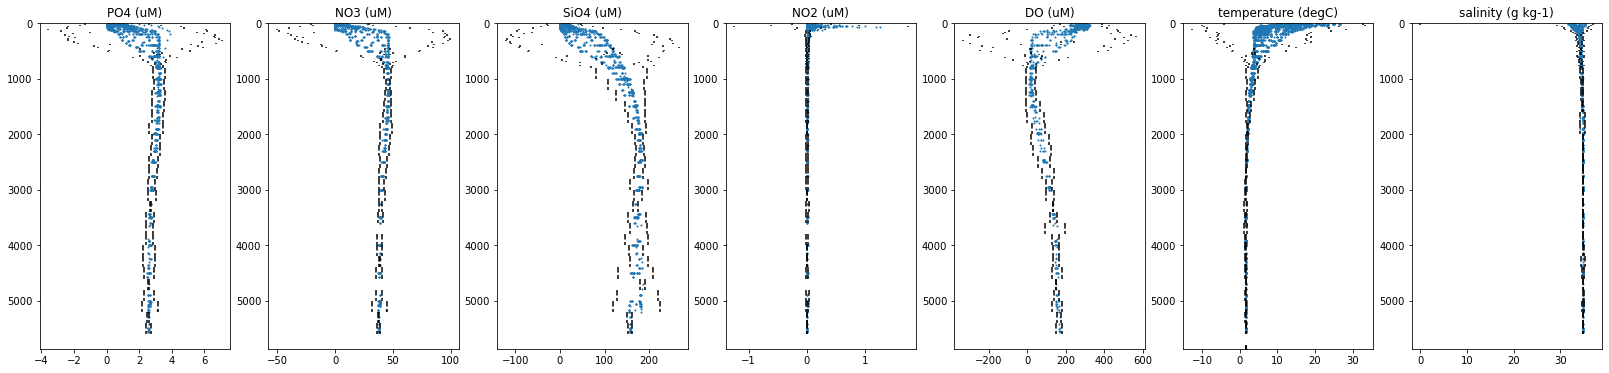

In [72]:
# lets see if there are any clear anomalies
test = ['PO4 (uM)', 'NO3 (uM)', 'SiO4 (uM)', 'NO2 (uM)', 'DO (uM)', 'temperature (degC)', 'salinity (g kg-1)']
fig, ax = plt.subplots(1,len(test), figsize = (len(test)*4, 6))

for i in range(len(test)):
    qaqc_plot(temp, test[i], ax[i])

In [73]:
# trim based on standard deviation 
for i in range(len(test)):
    temp[test[i]] = qaqc_trim(temp, test[i])

# and add to df
ob = pd.concat([ob, temp])

In [74]:
lp = pd.read_csv("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/GEOTRACES/TM_LineP_2012-2020_RobynTaves.csv").drop([0], axis=0).reset_index().drop(['index'], axis=1)
lp

# convert to correct units
# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime([lp['Start Date (UTC)'][i] +' '+lp['Start Time (UTC)'][i]  for i in lp.index])
temp['longitude (degrees_east)'] = lp['Start Longitude']
temp['latitude (degrees_north)'] = lp['Start Latitude']
temp['pressure (dbar)'] = lp['Depth']
temp['depth (m)'] = lp['Depth']
temp['Mn (nM)'] = lp['Mn_D_CONC_BOTTLE']
temp['Fe (nM)'] = lp['Fe_D_CONC_BOTTLE']
temp['Co (nM)'] = lp['Co_D_CONC_BOTTLE']
temp['Ni (nM)'] = lp['Ni_D_CONC_BOTTLE']
temp['Cu (nM)'] = lp['Cu_D_CONC_BOTTLE']
temp['Zn (nM)'] = lp['Zn_D_CONC_BOTTLE']
temp['Cd (nM)'] = lp['Cd_D_CONC_BOTTLE']
# consider adding sigma to the dataset

temp['source'] ="GEOTRACES"

ob = pd.concat([ob, temp])

## Remove Repetition
Based on datetime (within one hour), depth, lat, lon

In [76]:
ob.columns

Index(['time', 'source', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn (nM)'],
      dtype='object')

In [77]:
ob['time'] = pd.to_datetime(ob.time, utc=True)
ob['longitude (degrees_east)'] = pd.to_numeric(ob['longitude (degrees_east)'], errors='coerce')
ob['latitude (degrees_north)'] = pd.to_numeric(ob['latitude (degrees_north)'], errors='coerce')
ob['depth (m)'] = pd.to_numeric(ob['depth (m)'], errors='coerce')
ob['pressure (dbar)'] = pd.to_numeric(ob['pressure (dbar)'], errors='coerce')
ob['temperature (degC)'] = pd.to_numeric(ob['temperature (degC)'], errors='coerce')
ob['salinity (g kg-1)'] = pd.to_numeric(ob['salinity (g kg-1)'], errors='coerce')
ob['DO (uM)'] = pd.to_numeric(ob['DO (uM)'], errors='coerce')
ob['NO3 (uM)'] = pd.to_numeric(ob['NO3 (uM)'], errors='coerce')
ob['NO2 (uM)'] = pd.to_numeric(ob['NO2 (uM)'], errors='coerce')
ob['NH4 (uM)'] = pd.to_numeric(ob['NH4 (uM)'], errors='coerce')
ob['PO4 (uM)'] = pd.to_numeric(ob['PO4 (uM)'], errors='coerce')
ob['SiO4 (uM)'] = pd.to_numeric(ob['SiO4 (uM)'], errors='coerce')
ob['DIC (uM)'] = pd.to_numeric(ob['DIC (uM)'], errors='coerce')
ob['TA (uM)'] = pd.to_numeric(ob['TA (uM)'], errors='coerce')
ob['Aragonite'] = pd.to_numeric(ob['Aragonite'], errors='coerce')
ob['Calcite'] = pd.to_numeric(ob['Calcite'], errors='coerce')
ob['Carbonate'] = pd.to_numeric(ob['Carbonate'], errors='coerce')
ob['Al (nM)'] = pd.to_numeric(ob['Al (nM)'], errors='coerce')
ob['Ba (nM)'] = pd.to_numeric(ob['Ba (nM)'], errors='coerce')
ob['Cd (nM)'] = pd.to_numeric(ob['Cd (nM)'], errors='coerce')
ob['Co (nM)'] = pd.to_numeric(ob['Co (nM)'], errors='coerce')
ob['Cu (nM)'] = pd.to_numeric(ob['Cu (nM)'], errors='coerce')
ob['Fe (nM)'] = pd.to_numeric(ob['Fe (nM)'], errors='coerce')
ob['Ga (nM)'] = pd.to_numeric(ob['Ga (nM)'], errors='coerce')
ob['Mn (nM)'] = pd.to_numeric(ob['Mn (nM)'], errors='coerce')
ob['Ni (nM)'] = pd.to_numeric(ob['Ni (nM)'], errors='coerce')
ob['Pb (nM)'] = pd.to_numeric(ob['Pb (nM)'], errors='coerce')
ob['Zn (nM)'] = pd.to_numeric(ob['Zn (nM)'], errors='coerce')

ob

,time,source,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),...,Ba (nM),Cd (nM),Co (nM),Cu (nM),Fe (nM),Ga (nM),Mn (nM),Ni (nM),Pb (nM),Zn (nM)
0,2008-11-19 00:00:00+00:00,ios mooring,-123.424450,49.027150,13.064797,13.177000,9.5504,28.577895,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2009-05-24 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.801180,40.143800,NaN,32.581284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2009-05-25 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.375910,39.714828,NaN,32.543773,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2009-05-26 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.293829,39.632032,NaN,32.522040,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,2009-05-27 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.336227,39.674800,NaN,32.530000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15075,2014-08-21 19:20:39.000025392+00:00,GEOTRACES,233.332993,48.649700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15076,2014-08-21 19:20:39.000025392+00:00,GEOTRACES,233.332993,48.649700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15077,2014-08-21 19:20:39.000025392+00:00,GEOTRACES,233.332993,48.649700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15078,2014-08-21 19:20:39.000025392+00:00,GEOTRACES,233.332993,48.649700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# sometimes things go wrong with CTDs.. so remove rows if salinity, temperature, or DO are acting crazy
ob.drop(ob.loc[ob['salinity (g kg-1)']>50].index, inplace=True)
ob.drop(ob.loc[ob['salinity (g kg-1)']<0].index, inplace=True)

ob.drop(ob.loc[ob['temperature (degC)']>40].index, inplace=True)
ob.drop(ob.loc[ob['temperature (degC)']<-3].index, inplace=True)

# otherwise if something's fishy, we dont want to drop the whole row but we also dont want to work with that value
ob['DO (uM)'][ob['DO (uM)']<0] = np.nan
ob['NO3 (uM)'][ob['NO3 (uM)']<0] = np.nan
ob['NO2 (uM)'][ob['NO2 (uM)']<0] = np.nan
ob['NH4 (uM)'][ob['NH4 (uM)']<0] = np.nan
ob['PO4 (uM)'][ob['PO4 (uM)']<0] = np.nan
ob['SiO4 (uM)'][ob['SiO4 (uM)']<0] = np.nan
ob['DIC (uM)'][ob['DIC (uM)']<0] = np.nan
ob['TA (uM)'][ob['TA (uM)']<0] = np.nan
ob['Chl (mg m-3)'][ob['Chl (mg m-3)']<0] = np.nan
ob['Carbonate'][ob['Carbonate']<0] = np.nan
ob['Aragonite'][ob['Aragonite']<0] = np.nan
ob['Calcite'][ob['Calcite']<0] = np.nan
ob['Al (nM)'][ob['Al (nM)']<0] = np.nan
ob['Ba (nM)'][ob['Ba (nM)']<0] = np.nan
ob['Cd (nM)'][ob['Cd (nM)']<0] = np.nan
ob['Co (nM)'][ob['Co (nM)']<0] = np.nan
ob['Cu (nM)'][ob['Cu (nM)']<0] = np.nan
ob['Fe (nM)'][ob['Fe (nM)']<0] = np.nan
ob['Ga (nM)'][ob['Ga (nM)']<0] = np.nan
ob['Mn (nM)'][ob['Mn (nM)']<0] = np.nan
ob['Ni (nM)'][ob['Ni (nM)']<0] = np.nan
ob['Pb (nM)'][ob['Pb (nM)']<0] = np.nan
ob['Zn (nM)'][ob['Zn (nM)']<0] = np.nan


In [79]:
# ok lets check some of the values we're having problems with
print('max = %s, min = %s, mean = %s' % (np.max(ob['NO3 (uM)']),np.min(ob['NO3 (uM)']),np.mean(ob['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(ob['PO4 (uM)']),np.min(ob['PO4 (uM)']),np.mean(ob['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(ob['SiO4 (uM)']),np.min(ob['SiO4 (uM)']),np.mean(ob['SiO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(ob['Chl (mg m-3)']),np.min(ob['Chl (mg m-3)']),np.mean(ob['Chl (mg m-3)'])))
print('max = %s, min = %s, mean = %s' % (np.max(ob['DO (uM)']),np.min(ob['DO (uM)']),np.mean(ob['DO (uM)'])))

max = 855.3548817981541, min = 0.0, mean = 19.863692397576052
max = 188.0, min = 0.0, mean = 26.511441656113064
max = 244.1542764909346, min = 0.0, mean = 12.251980589726365
max = 47.1056, min = 0.0, mean = 1.8802273165660206
max = 1139.426611947233, min = 0.0, mean = 107.54231059148748


In [80]:
df = ob
df['longitude (degrees_east)'] = df['longitude (degrees_east)'].round(2)
df['latitude (degrees_north)'] = df['latitude (degrees_north)'].round(2)
df['depth (m)'] = df['depth (m)'].round(0)  # Round depth to the nearest meter
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.floor('H')  # Round time to nearest hour

# Define a custom aggregation function
def aggregate_sources(series):
    return ', '.join(series.unique())
    
# Create an aggregation dictionary to apply 'mean' to numerical columns and the custom function for 'source'
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()  # Select only numeric columns
aggregation_dict = {col: 'mean' for col in numeric_columns if col not in ['longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)']}

# For non-numeric columns, such as 'source', use a custom aggregation function
aggregation_dict['source'] = aggregate_sources

# Group by time, longitude, latitude, and depth, then aggregate using the defined rules
grouped_df = df.groupby(['time', 'longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)']).agg(aggregation_dict).reset_index()



In [81]:
grouped_df

,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),NO2 (uM),...,Cd (nM),Co (nM),Cu (nM),Fe (nM),Ga (nM),Mn (nM),Ni (nM),Pb (nM),Zn (nM),source
0,1930-11-07 00:00:00+00:00,-123.77,49.25,4.0,3.698170,NaN,28.888956,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
1,1930-11-07 00:00:00+00:00,-123.77,49.25,18.0,18.155176,NaN,29.828912,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
2,1930-11-07 00:00:00+00:00,-123.77,49.25,27.0,27.233364,NaN,29.898754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
3,1930-11-07 00:00:00+00:00,-123.77,49.25,46.0,46.399742,NaN,30.391262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
4,1930-11-07 00:00:00+00:00,-123.77,49.25,91.0,91.800900,NaN,30.955366,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464015,2024-07-10 00:00:00+00:00,-124.77,49.49,21.0,21.000000,11.930936,26.584717,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3464016,2024-07-10 00:00:00+00:00,-124.77,49.49,42.0,42.000000,11.364086,29.618968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3464017,2024-07-10 00:00:00+00:00,-124.57,46.99,0.0,0.000000,9.221782,33.383366,57.119501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi
3464018,2024-07-10 00:00:00+00:00,-124.56,46.99,0.0,0.000000,11.482587,32.719748,569.742899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi


In [82]:
set(grouped_df.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI PNW',
 'NHL',
 'OCNMS',
 'department of ecology',
 'ios bottle',
 'ios bottle, NCEI PNW',
 'ios ctd profiles',
 'ios ctd profiles, NCEI PNW',
 'ios ctd profiles, ios bottle',
 'ios ctd profiles, ios bottle, NCEI PNW',
 'ios mooring',
 'ios mooring, ios bottle',
 'ios mooring, ios ctd profiles',
 'ios mooring, ios ctd profiles, ios bottle',
 'onc',
 'ooi'}

### Plot distribution of observations for each tracer

In [83]:
ob = grouped_df

In [84]:
ob

,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),NO2 (uM),...,Cd (nM),Co (nM),Cu (nM),Fe (nM),Ga (nM),Mn (nM),Ni (nM),Pb (nM),Zn (nM),source
0,1930-11-07 00:00:00+00:00,-123.77,49.25,4.0,3.698170,NaN,28.888956,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
1,1930-11-07 00:00:00+00:00,-123.77,49.25,18.0,18.155176,NaN,29.828912,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
2,1930-11-07 00:00:00+00:00,-123.77,49.25,27.0,27.233364,NaN,29.898754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
3,1930-11-07 00:00:00+00:00,-123.77,49.25,46.0,46.399742,NaN,30.391262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
4,1930-11-07 00:00:00+00:00,-123.77,49.25,91.0,91.800900,NaN,30.955366,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464015,2024-07-10 00:00:00+00:00,-124.77,49.49,21.0,21.000000,11.930936,26.584717,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3464016,2024-07-10 00:00:00+00:00,-124.77,49.49,42.0,42.000000,11.364086,29.618968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3464017,2024-07-10 00:00:00+00:00,-124.57,46.99,0.0,0.000000,9.221782,33.383366,57.119501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi
3464018,2024-07-10 00:00:00+00:00,-124.56,46.99,0.0,0.000000,11.482587,32.719748,569.742899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi


In [85]:
columns_to_count = ob.columns.drop(['time', 'longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)', 'source', 'pressure (dbar)'])

In [86]:
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

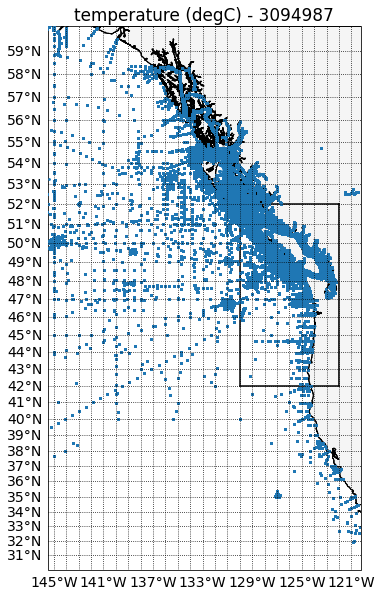

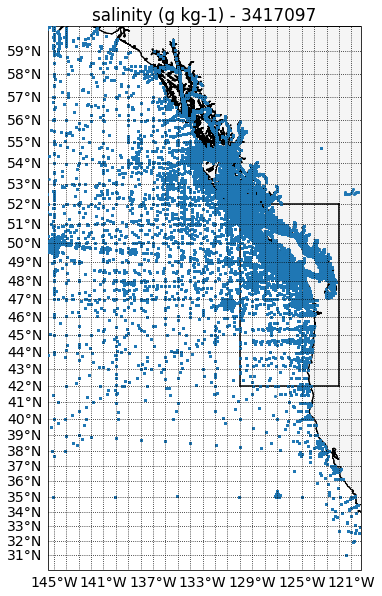

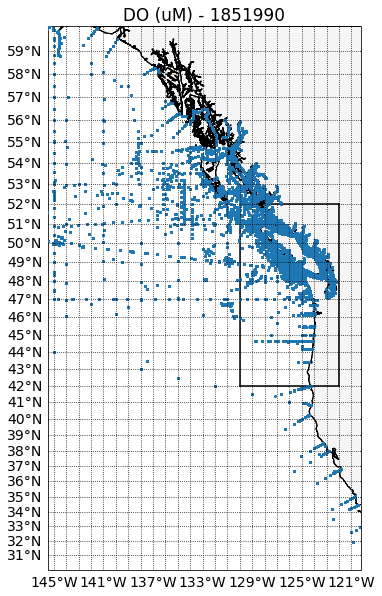

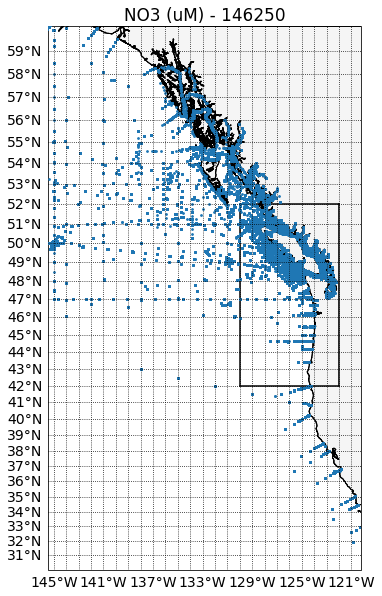

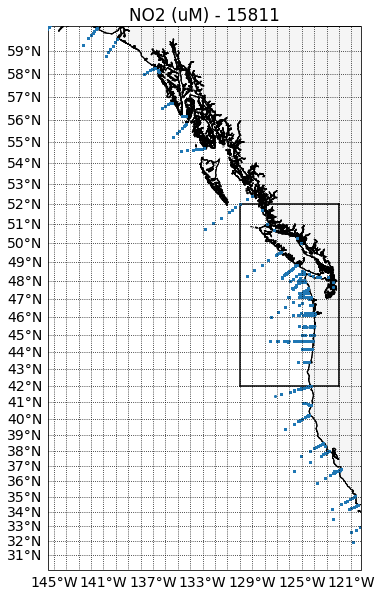

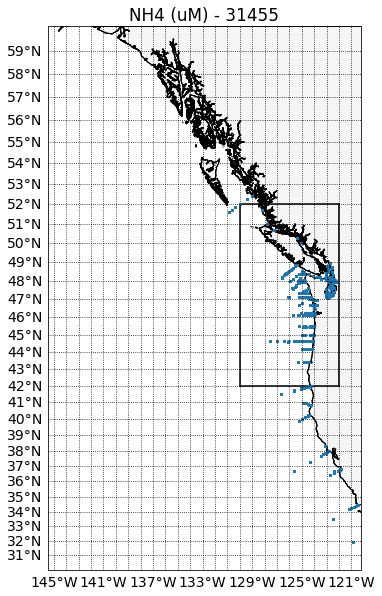

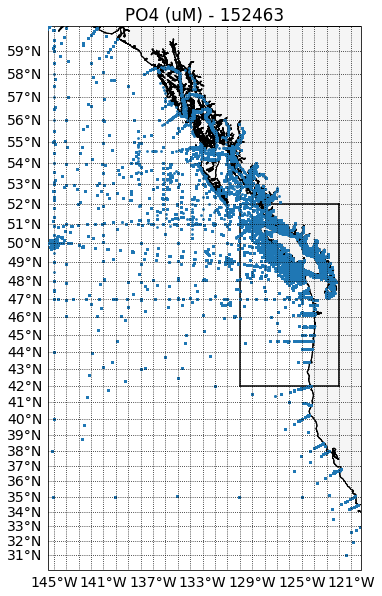

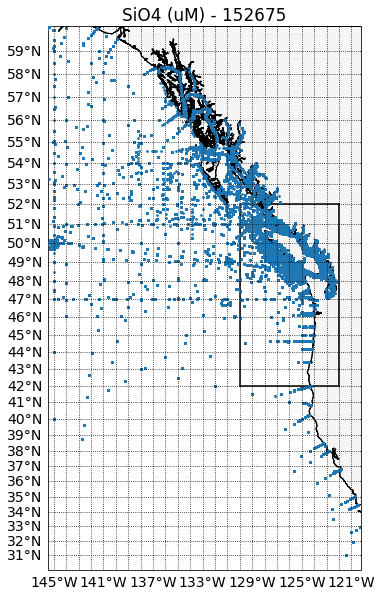

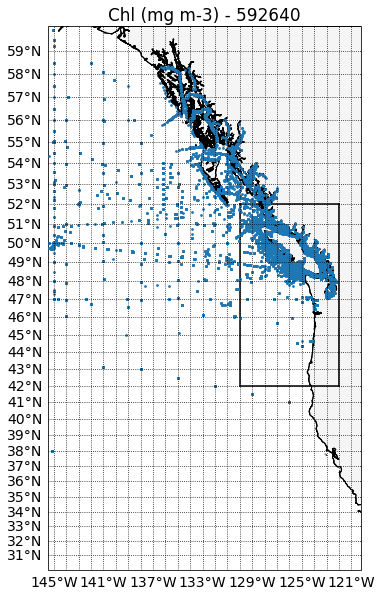

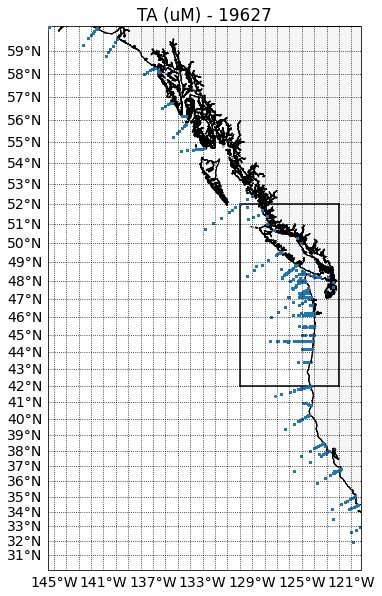

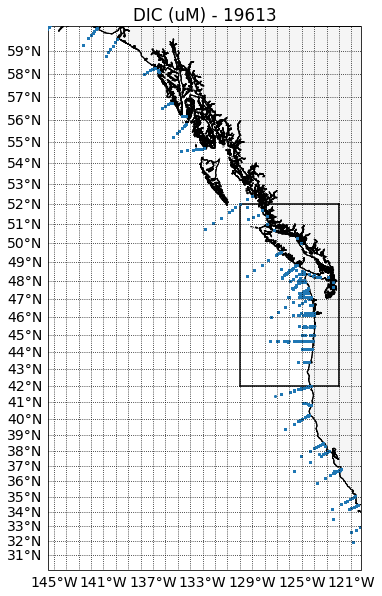

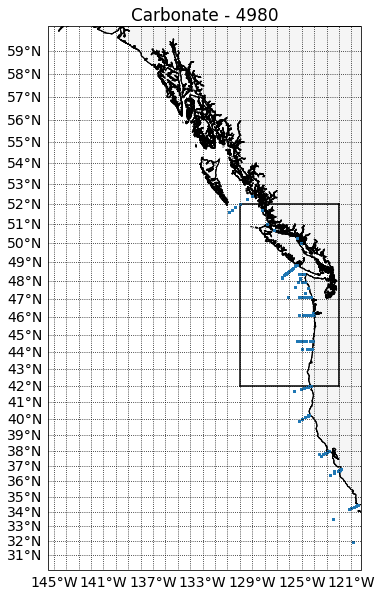

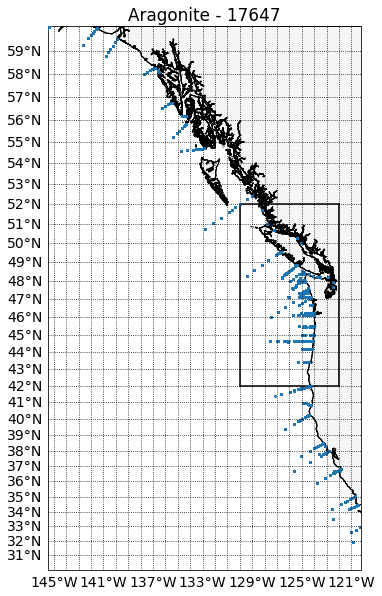

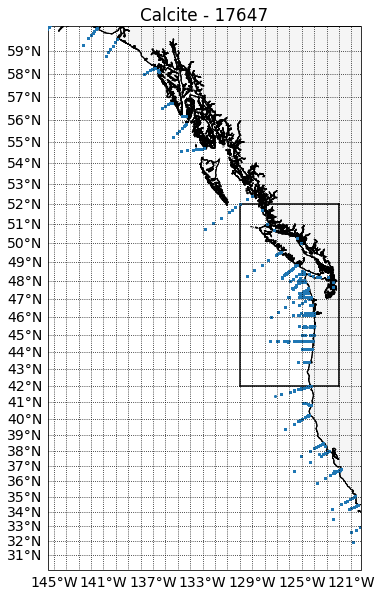

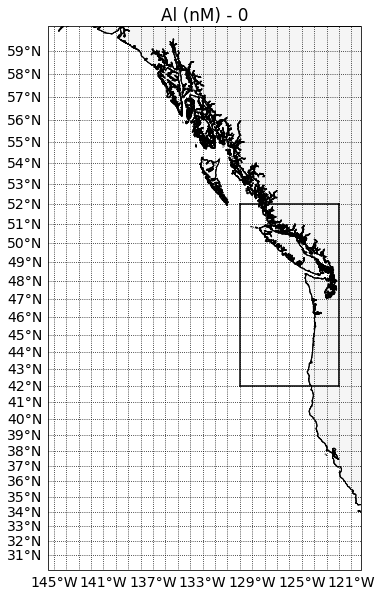

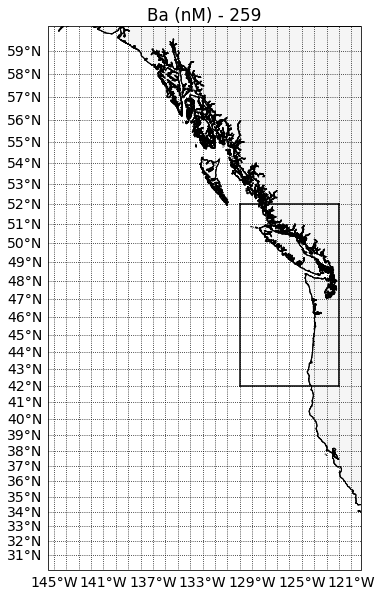

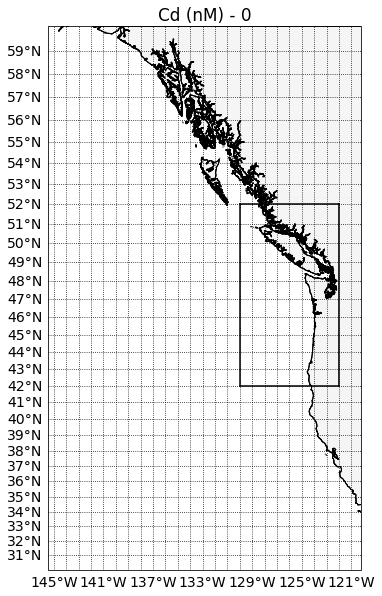

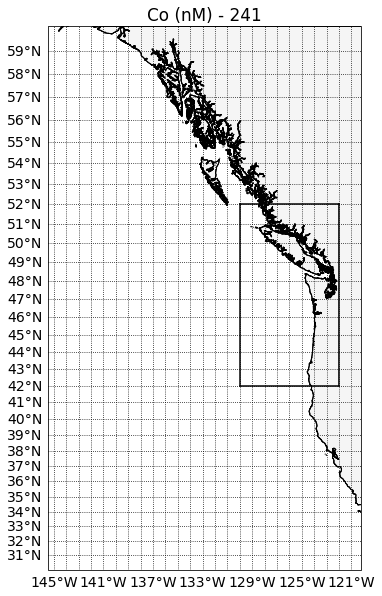

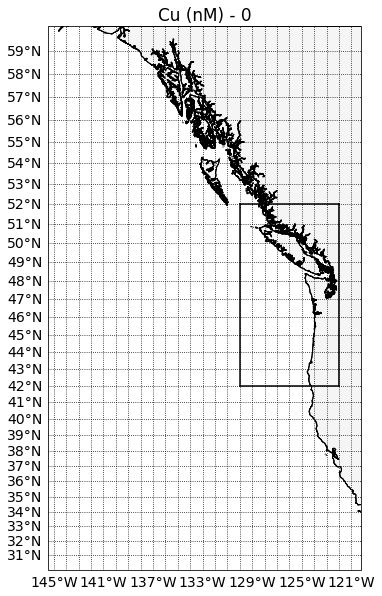

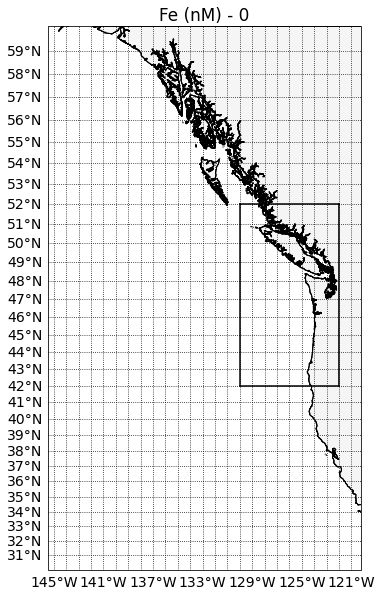

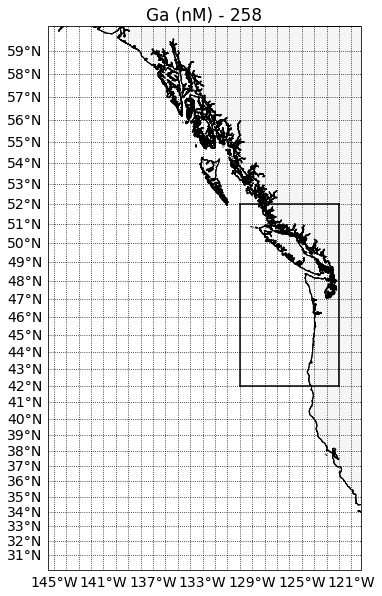

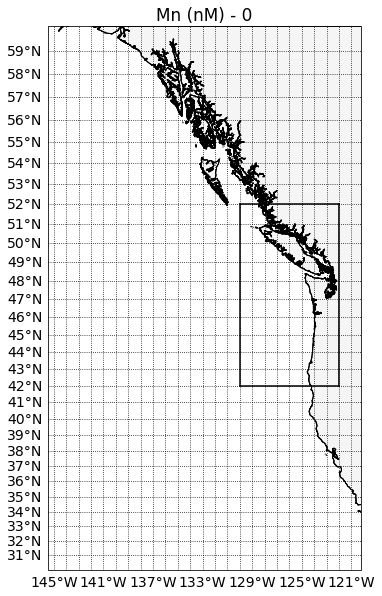

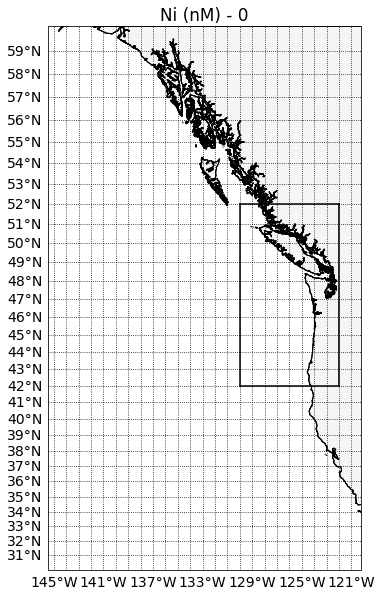

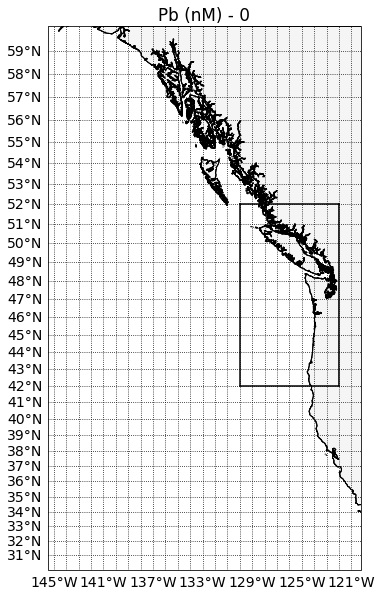

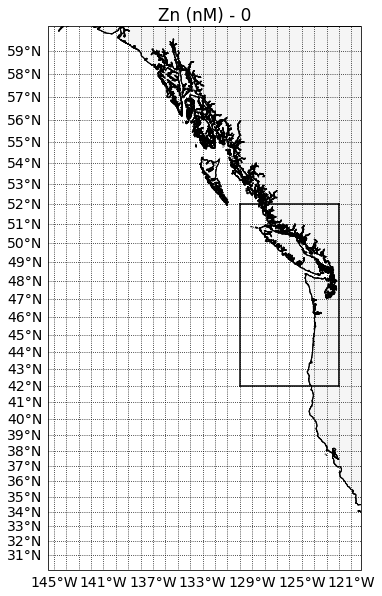

In [87]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

for tracer in columns_to_count:
    # Increase font size
    plt.rcParams['font.size'] = 14

    # Make plot area
    xlim, ylim = [-145.5, -120.2], [30, 60]
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
    ax.set_extent(xlim + ylim)

    # Draw coastline
    ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

    # Add gridlines
    xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
    gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
    gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.top_labels, gl.right_labels = False, False

    # Draw box
    ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

    # add points
    ax.scatter(ob['longitude (degrees_east)'][~np.isnan(ob[tracer])], ob['latitude (degrees_north)'][~np.isnan(ob[tracer])], s=3, transform=crs.PlateCarree(),zorder=7)

    title = "{} - {}".format(tracer,np.sum(~np.isnan(ob[tracer])))
    ax.set_title(title)

In [84]:
set(ob.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI PNW',
 'NCEI PNW, GEOTRACES',
 'NHL',
 'OCNMS',
 'department of ecology',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios ctd profiles',
 'ios ctd profiles, NCEI PNW',
 'ios ctd profiles, ios bottle',
 'ios ctd profiles, ios bottle, GEOTRACES',
 'ios ctd profiles, ios bottle, NCEI PNW',
 'ios mooring',
 'ios mooring, ios bottle',
 'ios mooring, ios ctd profiles',
 'ios mooring, ios ctd profiles, ios bottle',
 'onc',
 'ooi'}

In [85]:
for tracer in columns_to_count:
    print(tracer)
    print(set(ob.source[~np.isnan(ob[tracer])]))
    print("\n")

temperature (degC)
{'ios bottle, NCEI PNW', 'ios ctd profiles, NCEI PNW', 'ios bottle', 'ios ctd profiles, ios bottle, GEOTRACES', 'ooi', 'ios ctd profiles, ios bottle', 'ios mooring, ios ctd profiles, ios bottle', 'NCEI Coastal', 'GEOTRACES', 'ios bottle, GEOTRACES', 'ios mooring', 'NCEI PNW', 'ios mooring, ios bottle', 'ios mooring, ios ctd profiles', 'OCNMS', 'NCEI PNW, GEOTRACES', 'onc', 'ios ctd profiles, ios bottle, NCEI PNW', 'department of ecology', 'ios ctd profiles', 'NHL'}


salinity (g kg-1)
{'ios bottle, NCEI PNW', 'ios ctd profiles, NCEI PNW', 'ios bottle', 'ios ctd profiles, ios bottle, GEOTRACES', 'ooi', 'ios ctd profiles, ios bottle', 'ios mooring, ios ctd profiles, ios bottle', 'NCEI Coastal', 'GEOTRACES', 'ios bottle, GEOTRACES', 'ios mooring', 'NCEI PNW', 'ios mooring, ios bottle', 'ios mooring, ios ctd profiles', 'OCNMS', 'NCEI PNW, GEOTRACES', 'onc', 'ios ctd profiles, ios bottle, NCEI PNW', 'department of ecology', 'ios ctd profiles', 'NHL'}


DO (uM)
{'ios bottl

In [86]:
ob.to_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')